# Multi-Task Learning Overview 

Multi-Task Learning: An Introduction

Bland Altman: https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot

School Papers:
   
2015 https://www.ijcai.org/Proceedings/15/Papers/512.pdf
   
2017 https://arxiv.org/pdf/1703.00977.pdf

2017 https://arxiv.org/pdf/1611.03427.pdf

data import: https://github.com/tjanez/PyMTL/blob/master/src/PyMTL/data.py

In Machine Learning, our traditional goal is to optimize and improve until we reach a specific goal or method. We do this by training a model (or more) and refining it until the performance improvement flatlines. However, while focused on this single task, we tend to leave out other pieces of potentially valuable information that could improve our score. In order to modify this, we present a Multi-Task (Multi-Output) model.

<img src="images/multi-task-graph.png" width="400">

An advantage to this type of model, is that while some of the hidden layers are shared among the data, they each have their own individual output layers, which greatly reduces the risk of overfitting. This is due to the model having a lot more data to learn from than it normally would.

By presenting a model with similar data but different goals, such as predicting scores of different schools around a country, we can make our overall performance better for our original task. Due to the split of data needed to train a multi-task model, one typically needs a very large, complete, and even dataset to train/test with.

In order to better demonstrate this model in action, we will first show an example on the previously mentioned school dataset, followed by a more complex ChemBL demonstration.

# School Data

## School Data Understanding

We will be using a UK school dataset comprised of 140 different school locations with a total of 15,000 students. Each student has 28 different features, each representing a demographic aspect (gender, age, etc).

To give a more detailed explanation of the data, this was taken from the data source itself:

Column    Description              Coding

     1         Year                     1985=1; 1986=2; 1987=3

     2-4       School                   Codes 1-139

     5-6       Exam Score               Numeric score

     7-8       % FSM                    Percent. students eligible for free
                                        school meals

     9-10      % VR1 band               Percent. students in school in VR band
                                        1

     11        Gender                   Male=0; Female=1

     12        VR band of student       VR1=2; VR2=3; VR3=1

     13-14     Ethnic group of          ESWI=1*; African=2; Arab=3;
               student                  Bangladeshi=4; Caribbean=5;
                                        Greek=6;Indian=7;Pakistani=8;
                                        S.E.Asian=9;Turkish=10; Other=11

                                        Mixed=1; Male=2; Female=3
     15        School gender
                                        Maintained=1; Church of
     16        School denomination      England=2; Roman Catholic=3

Originally there were only 16 features, but the categorical ones were replace with a binary feature for each possible value. In total, there were 27 plus the bias term. Each school is treated as an individual task and the exam score is the target.

In this notebooke will be exploring three different ways to create a classifier and compare their performances.
In the next few sections, we will be showing three different methods of completing the task on this data: 1) running each school through its own model, 2) running all the schools together into one model, 3) using a Multi-Task approach and having some of the layers shared by each school, and some individual.

## School Data Processing

Unfortunately this is an extremely messy dataset so we have quite a bit of preprocessing that we will need to perform.

In [116]:
%matplotlib inline
import scipy.io
from sklearn.datasets.base import Bunch
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# load the data for each individual school
school_indices = [scipy.io.loadmat('data/school_splits/school_%d_indexes.mat' % (x)) for x in range(1, 11)]
raw_data = scipy.io.loadmat('data/school_splits/school_b.mat')

In [117]:
# changed data to float because yhat will be floats
X = np.array(raw_data['x'].T)
y = np.array(raw_data['y'])
print("We have an input array of shape:", X.shape)
print("We have an output array of shape:", y.shape)

We have an input array of shape: (15362, 28)
We have an output array of shape: (15362, 1)


In [118]:
# Matlab - arrays are indexed at 1, needs adapting
start_index = np.ravel(raw_data["task_indexes"] - 1)

In [119]:
tasks = []
for i in range(len(start_index)):
    start = start_index[i]
    if i == len(start_index) - 1:
        end = -1
    else:
        end = start_index[i + 1]
    descr = "School data: school {}".format(i + 1)
    id = "School {}".format(i + 1)
    tasks.append(Bunch(data=X[start:end],
                       target=y[start:end],
                       DESCR=descr,
                       ID=id))

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

## Independent School Models

First, let's train each school on its own individual model.
Each of the 141 models will only have an average of 107.4 data points between both train and test data.

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten

Using TensorFlow backend.


In [10]:
models_ind = []
test_daters_ind = []
for x in tasks:
    #X_train = x.data
    #y_train = x.target
    X_train, X_test, y_train, y_test = train_test_split(x.data, x.target, test_size=0.2, random_state=42)

    mlp = Sequential()
    mlp.add(Dense(input_dim=X_train.shape[1], units=30, activation='relu'))
    mlp.add( Dense(units=15, activation='relu') )
    mlp.add(Dense(1))

    mlp.compile(loss='mean_squared_error',
                optimizer='rmsprop',
                metrics=[])
    
    mlp.fit(X_train, y_train, epochs=20, shuffle=True, verbose=0)
    models_ind.append(mlp)
    test_daters_ind.append([X_test, y_test])

In [55]:
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, mean_squared_log_error

y_ind=[]
yhat_ind=[]

mses=[]
plt.figure(figsize=(15,10))

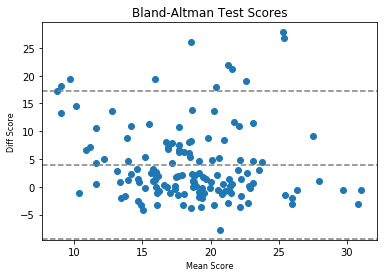

In [56]:
for t, mlp in zip(test_daters_ind, models_ind):
    X_test, y_test = t

    yhat_mlp = mlp.predict(X_test)
    yhat_rounded = np.around(yhat_mlp)
    
    y_test_plot = y_test.ravel()
    yhat_mlp_plot = yhat_mlp.ravel()
    
    y_ind.append(np.mean(y_test_plot))
    yhat_ind.append(np.mean(yhat_mlp_plot))

    mse = mean_squared_error(y_test, yhat_mlp)
    mses.append(mse)
    
bland_altman_plot(y_ind, yhat_ind)
plt.title('Bland-Altman Test Scores')
plt.xlabel('Mean Score', fontsize=8)
plt.ylabel('Diff Score', fontsize=8)
plt.show()

This graph has a linear line running through it, while we plot a dot with x being the actual value of the school exam score while y is the predicted value. The closer a dot is to the linear line, the more accurate the score. If the dot is under the linear line, our model low balled the prediction, and vise-versa. 

In [51]:
avg = float(np.mean(mses))
print ("Average of Mean Squared Error: ", avg)

Average of Mean Squared Error:  198.29652404785156


By using Avg Mean Square Error, we can see how close we are to the line of best fit. Based on the graph, we can already tell we are not close.

## General School Model

Let's see if using a single model for all the schools increases our accuracy.  We will have one model with all 15000 training instances.

In [52]:
all_data = {"data": [], "target": [], "data_test": [], "target_test": []}
for bunch in tasks:
    x_temp, y_temp = [bunch.data, bunch.target]
    X_train, X_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)
    all_data["data"].append(X_train)
    all_data["target"].append(y_train)        
    all_data["data_test"].append(X_test)
    all_data["target_test"].append(y_test)

X_train = np.concatenate(all_data["data"])
y_train = np.concatenate(all_data["target"])

In [53]:
generalized_mlp = Sequential()
generalized_mlp.add(Dense(input_dim=X_train.shape[1], units=30, activation='relu'))
generalized_mlp.add(Dense(units=15, activation='relu'))
generalized_mlp.add(Dense(1))

generalized_mlp.compile(loss='mean_squared_error',
            optimizer='rmsprop',
            metrics=[])

generalized_mlp.fit(X_train, y_train, epochs=20, shuffle=True, verbose=0)

In [61]:
y_general=[]
yhat_general=[]

mses_general=[]
plt.figure(figsize=(15,10))

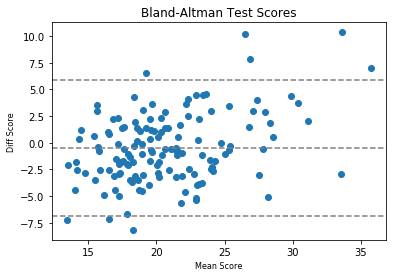

In [62]:
for X_test, y_test in zip(all_data["data_test"], all_data["target_test"]):
    yhat_mlp = generalized_mlp.predict(X_test)
    yhat_rounded = np.around(yhat_mlp)
    
    y_test_plot = y_test.ravel()
    yhat_mlp_plot = yhat_mlp.ravel()
    
    y_general.append(np.mean(y_test_plot))
    yhat_general.append(np.mean(yhat_mlp_plot))
    
    mse = mean_squared_error(y_test, yhat_mlp)
    mses_general.append(mse)
    
bland_altman_plot(y_general, yhat_general)
plt.title('Bland-Altman Test Scores')
plt.xlabel('Mean Score', fontsize=8)
plt.ylabel('Diff Score', fontsize=8)
plt.show()

In [63]:
avg = float(np.mean(mses_general))
print ("Average of Mean Squared Error: ", avg)

Average of Mean Squared Error:  105.4157485961914


Our Avg Mean Squared Error is significantly better, clearly showing better results, although we still have an issue of underpredicting at higher test scores.

## School Multi-Task Model

### mean_squared_error

In [64]:
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X[0].shape[0],))
shared_mlp = Dense(64, activation='relu')(inputs)
shared_mlp = Dense(64, activation='relu')(shared_mlp)

models_mtl = []

for _ in range(len(tasks)):
    personal_layer = Dense(10, activation='relu')(shared_mlp)
    output_layer = Dense(1)(personal_layer)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    models_mtl.append(model)

In [128]:
all_data = []
all_test = []

weights = {}
for bunch in tasks:
    ID = int(bunch.ID.split(" ")[-1]) - 1
    X_train, X_test, y_train, y_test = train_test_split(bunch.data, bunch.target, test_size=0.4, random_state=42)
    for row, target in zip(X_train, y_train):
        instance = {}
        instance["data"] = row.reshape((1, 28))
        instance["school"] = ID
        instance["target"] = target
        all_data.append(instance)
        
    for row, target in zip(X_test, y_test):
        instance = {}
        instance["data"] = row.reshape((1, 28))
        instance["school"] = ID
        instance["target"] = target
        all_test.append(instance)

After separating the data correctly, shuffle it all back together and run it through 20 epochs on the shared model.

In [129]:
import random
random.shuffle(all_data)

In [130]:
EPOCHS = 20
for _underscore in range(20):
    for instance in all_data:
        models_mtl[instance["school"]].train_on_batch(instance["data"], instance["target"])

In [131]:
y_mtl=[]
yhat_mtl=[]

plt.figure(figsize=(15,10))
mses_mtl=[]

In [132]:
school_y = [ [] for x in range(139)]
school_yhat = [ [] for x in range(139)]

for test in all_test:
    X_test = test["data"]
    y_test = test["target"]
    
    mlp = models_mtl[test["school"]]
    
    yhat_mlp = mlp.predict(X_test)
    yhat_rounded = np.around(yhat_mlp)
    
    y_test_plot = y_test.ravel()
    yhat_mlp_plot = yhat_mlp.ravel()

    school_y[test["school"]].append(y_test_plot)
    school_yhat[test["school"]].append(yhat_mlp_plot)

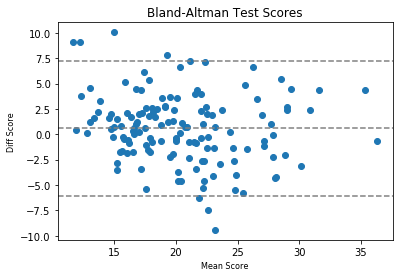

In [133]:
for x, y in zip(school_y, school_yhat):
    y_mtl.append(np.mean(x))
    yhat_mtl.append(np.mean(y))
    
    mse = mean_squared_error(x, y)
    mses_mtl.append(mse)
    
bland_altman_plot(y_mtl, yhat_mtl)
plt.title('Bland-Altman Test Scores')
plt.xlabel('Mean Score', fontsize=8)
plt.ylabel('Diff Score', fontsize=8)
plt.show()

In [134]:
avg = float(np.mean(mses_mtl))
print ("Average of Mean Squared Error: ", avg)

Average of Mean Squared Error:  114.21878814697266


### mean_absolute_error

In [135]:
from sklearn.metrics import mean_absolute_error

inputs = Input(shape=(X[0].shape[0],))
shared_mlp = Dense(64, activation='relu')(inputs)
shared_mlp = Dense(64, activation='relu')(shared_mlp)

models_mtl = []

for _ in range(len(tasks)):
    personal_layer = Dense(10, activation='relu')(shared_mlp)
    output_layer = Dense(1)(personal_layer)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    models_mtl.append(model)

In [138]:
all_data = []
all_test = []

weights = {}
for bunch in tasks:
    ID = int(bunch.ID.split(" ")[-1]) - 1
    X_train, X_test, y_train, y_test = train_test_split(bunch.data, bunch.target, test_size=0.4, random_state=42)
    for row, target in zip(X_train, y_train):
        instance = {}
        instance["data"] = row.reshape((1, 28))
        instance["school"] = ID
        instance["target"] = target
        all_data.append(instance)
        
    for row, target in zip(X_test, y_test):
        instance = {}
        instance["data"] = row.reshape((1, 28))
        instance["school"] = ID
        instance["target"] = target
        all_test.append(instance)

In [139]:
import random
random.shuffle(all_data)

In [140]:
EPOCHS = 20
for _underscore in range(20):
    for instance in all_data:
        models_mtl[instance["school"]].train_on_batch(instance["data"], instance["target"])

In [141]:
y_mtla=[]
yhat_mtla=[]

plt.figure(figsize=(15,10))
maes_mtl=[]

In [142]:
school_ya = [ [] for x in range(139)]
school_yhata = [ [] for x in range(139)]

for test in all_test:
    X_test = test["data"]
    y_test = test["target"]
    
    mlp = models_mtl[test["school"]]
    
    yhat_mlp = mlp.predict(X_test)
    yhat_rounded = np.around(yhat_mlp)
    
    y_test_plot = y_test.ravel()
    yhat_mlp_plot = yhat_mlp.ravel()

    school_ya[test["school"]].append(y_test_plot)
    school_yhata[test["school"]].append(yhat_mlp_plot)

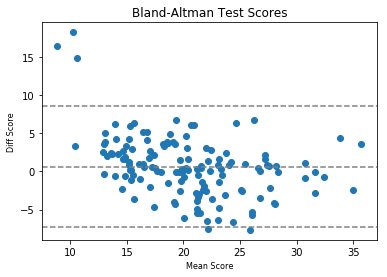

In [143]:
for x, y in zip(school_ya, school_yhata):
    y_mtla.append(np.mean(x))
    yhat_mtla.append(np.mean(y))
    
    mae = mean_absolute_error(x, y)
    maes_mtl.append(mse)
    
bland_altman_plot(y_mtla, yhat_mtla)
plt.title('Bland-Altman Test Scores')
plt.xlabel('Mean Score', fontsize=8)
plt.ylabel('Diff Score', fontsize=8)
plt.show()

In [144]:
avg = float(np.mean(maes_mtl))
print ("Average of Mean Absolute Error: ", avg)

Average of Mean Absolute Error:  62.09855651855469


So the results were a bit dissapointing. It turns out the General Model proved best for this problem, but that could be due to a variety of reasons, such as lack of data or a poorly built Multi Task model. However, it should be noted that while teh Avg Mean Squared Error is higher, the graph shows that the problem of overfitting to low test scores is less in the Multi Task Model than the other previous two. So while it did score a higher error value, it did prove better on solving the overfitting problem.

Now we will move on to a more complex and bigger dataset for you to try this out.

# Computer Survey Data

### Computer Survey Data Understanding
This data set was obtained on pmtkdata project's web site:
    https://code.google.com/p/pmtkdata/.
It was used by "Argyriou, Evgeniou, Pontil - Convex multi-task feature learning - ML 2008" and "Kumar, Daume III - Learning Task Grouping and Overlap in Multi-Task Learning - ICML 2012".

The data set's properties are:
   
20 samples (all subjects have the same samples)
13 features (describing computer's intrinsic (e.g. CPU speed, RAM) and extrinsic (e.g. Hot line support, Color of unit) features)
regression task of predicting subject's likelihood of purchasing a personal computer
   
Each data point is 20 x 14, which is each of the computers for that respective student. The computers are the students and the students are the school while the ratings are the test scores and the comp specs are the demographs.

In [207]:
%matplotlib inline
import os.path
import scipy.io
from sklearn.datasets.base import Bunch
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

def load_computer_survey_data():
    """
    Returns
    -------
    tasks -- list
        A list of Bunch objects that correspond to regression tasks, each task
        corresponding to one subject.
    """
    
    matlab_file = os.path.join("data/data/computer/conjointAnalysisComputerBuyers.mat")
    mat = loadmat(matlab_file)
    # feature names are taken from the ComputerSurveyFull.xls file, Sheet named
    # Design Matrix
    feature_names = ["cnst", "Hot line", "RAM", "Screen size", "CPU speed",
                     "Hard disk", "CD ROM", "Cache", "Color of unit",
                     "Availability", "Warranty", "Software", "Guarantee",
                     "Price"]
    # extract X and combined y data
    X = mat["designMarix"].astype("float")
    y_combined = mat["likeBuy"].astype("float")
    # create a task for each subject
    tasks = []
    for subject in range(len(y_combined)):
        descr = "Computer Survey data: Subject {}".format(subject)
        id = "Subject {}".format(subject)
        y = np.array(y_combined[subject], copy=True)
        tasks.append(Bunch(data=X,
                           target=y,
                           feature_names=feature_names,
                           DESCR=descr,
                           ID=id))
    return tasks

In [208]:
comp_tasks = load_computer_survey_data()

FileNotFoundError: [Errno 2] No such file or directory: 'data/data/computer_survey/conjointAnalysisComputerBuyers.mat'

## Individual Computer Model

In [83]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, mean_squared_log_error

In [86]:
modelsc_ind = []
testc_daters_ind = []
for x in comp_tasks:
    X_train, X_test, y_train, y_test = train_test_split(x.data, x.target, test_size=0.25, random_state=42)

    mlp = Sequential()
    mlp.add(Dense(input_dim=X_train.shape[1], units=30, activation='relu'))
    mlp.add( Dense(units=15, activation='relu') )
    mlp.add(Dense(1))

    mlp.compile(loss='mean_squared_error',
                optimizer='rmsprop',
                metrics=[])
    
    mlp.fit(X_train, y_train, epochs=10, shuffle=True, verbose=0)
    modelsc_ind.append(mlp)
    testc_daters_ind.append([X_test, y_test])

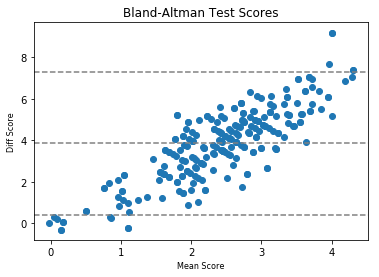

In [91]:
yc_ind=[]
yhatc_ind=[]

msesc=[]
plt.figure(figsize=(15,10))

for t, mlp in zip(testc_daters_ind, modelsc_ind):
    X_test, y_test = t

    yhat_mlp = mlp.predict(X_test)
    yhat_rounded = np.around(yhat_mlp)
    
    y_test_plot = y_test.ravel()
    yhat_mlp_plot = yhat_mlp.ravel()
    
    yc_ind.append(np.mean(y_test_plot))
    yhatc_ind.append(np.mean(yhat_mlp_plot))

    mse = mean_squared_error(y_test, yhat_mlp)
    msesc.append(mse)
    
bland_altman_plot(yc_ind, yhatc_ind)
plt.title('Bland-Altman Test Scores')
plt.xlabel('Mean Score', fontsize=8)
plt.ylabel('Diff Score', fontsize=8)
plt.show()

In [96]:
avg = float(np.mean(msesc))
print ("Average of Mean Squared Error: ", avg)

Average of Mean Squared Error:  22.67564072574839


## General Computer Model

In [105]:
import matplotlib.pyplot as plt
import numpy as np

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

In [198]:
all_comp_data = {"data": [], "target": [], "data_test": [], "target_test": []}
for bunch in comp_tasks:
    x_temp, y_temp = [bunch.data, bunch.target]
    X_train, X_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)
    all_comp_data["data"].append(X_train)
    all_comp_data["target"].append(y_train)        
    all_comp_data["data_test"].append(X_test)
    all_comp_data["target_test"].append(y_test)

X_train_comp = np.concatenate(all_comp_data["data"])
y_train_comp = np.concatenate(all_comp_data["target"]).reshape(2850, 1)

In [199]:
print(X_train_comp.shape)
print(y_train_comp.shape)

(2850, 14)
(2850, 1)


In [200]:
generalizedc_mlp = Sequential()
generalizedc_mlp.add(Dense(input_dim=X_train_comp.shape[1], units=20, activation='relu'))
generalizedc_mlp.add(Dense(units=10, activation='relu'))
generalizedc_mlp.add(Dense(1))

generalizedc_mlp.compile(loss='mean_squared_error',
            optimizer='rmsprop',
            metrics=[])

generalizedc_mlp.fit(X_train_comp, y_train_comp, epochs=20, shuffle=True, verbose=0)

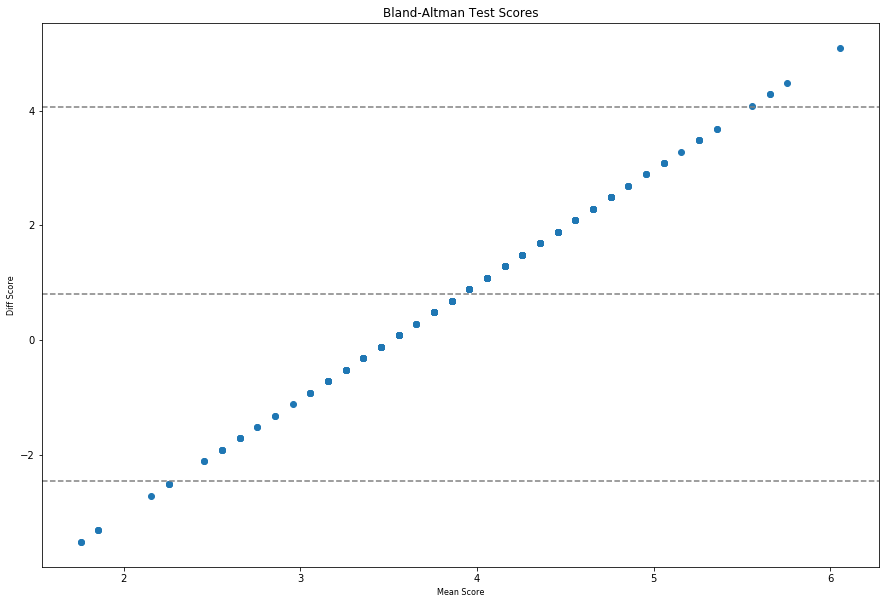

In [201]:
yc_general=[]
yhatc_general=[]

msesc_general=[]
plt.figure(figsize=(15,10))

for X_test, y_test in zip(all_comp_data["data_test"], all_comp_data["target_test"]):
    yhat_mlp = generalizedc_mlp.predict(X_test)

    y_test_plot = y_test.ravel()
    yhat_mlp_plot = yhat_mlp.ravel()
    
    yc_general.append(np.mean(y_test_plot))
    yhatc_general.append(np.mean(yhat_mlp_plot))
    
    mse = mean_squared_error(y_test, yhat_mlp)
    msesc_general.append(mse)

bland_altman_plot(yc_general, yhatc_general)
plt.title('Bland-Altman Test Scores')
plt.xlabel('Mean Score', fontsize=8)
plt.ylabel('Diff Score', fontsize=8)
plt.show()

In [161]:
avg = float(np.mean(msesc_general))
print ("Average of Mean Squared Error: ", avg)

Average of Mean Squared Error:  8.136600624771182


## Computer Survey Multi-Task Model

In [193]:
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X_train_comp.shape[1],))
shared_mlp = Dense(64, activation='relu')(inputs)
shared_mlp = Dense(64, activation='relu')(shared_mlp)

models_mtl = []

for _ in range(len(comp_tasks)):
    personal_layer = Dense(10, activation='relu')(shared_mlp)
    output_layer = Dense(1)(personal_layer)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    models_mtl.append(model)

In [194]:
all_comp_data = []
all_comp_test = []

weights = {}
for bunch in comp_tasks:
    ID = int(bunch.ID.split(" ")[-1])
    X_train, X_test, y_train, y_test = train_test_split(bunch.data, bunch.target, test_size=0.25, random_state=42)
    for row, target in zip(X_train, y_train):
        instance = {}
        instance["data"] = row.reshape((1, 14))
        instance["subject"] = ID
        instance["target"] = target.reshape((1,))
        all_comp_data.append(instance)
        
    for row, target in zip(X_test, y_test):
        instance = {}
        instance["data"] = row.reshape((1, 14))
        instance["subject"] = ID
        instance["target"] = target.reshape((1,))
        all_comp_test.append(instance)

In [195]:
import random
random.shuffle(all_comp_data)

In [196]:
EPOCHS = 5
for _underscore in range(5):
    for instance in all_comp_data:
        models_mtl[instance["subject"]].train_on_batch(instance["data"], instance["target"])

KeyboardInterrupt: 

In [ ]:
yc_mtl=[]
yhatc_mtl=[]

plt.figure(figsize=(15,10))
msesc_mtl=[]

computer_ya = [ [] for x in range(189)]
computer_yhata = [ [] for x in range(189)]

for test in all_comp_est:
    X_test = test["data"]
    y_test = test["target"]
    
    mlp = models_mtl[test["subject"]]
    
    yhat_mlp = mlp.predict(X_test)
    yhat_rounded = np.around(yhat_mlp)
    
    y_test_plot = y_test.ravel()
    yhat_mlp_plot = yhat_mlp.ravel()

    computer_ya[test["subject"]].append(y_test_plot)
    computer_yhata[test["subject"]].append(yhat_mlp_plot)

In [ ]:
plt.figure(figsize=(15,10))

for x, y in zip(computer_y, computer_yhat):
    yc_mtl.append(np.mean(x))
    yhatc_mtl.append(np.mean(y))
    
    mse = mean_squared_error(x, y)
    mses_mtl.append(mse)
    
bland_altman_plot(yc_mtl, yhatc_mtl)
plt.title('Bland-Altman Test Scores')
plt.xlabel('Mean Score', fontsize=8)
plt.ylabel('Diff Score', fontsize=8)
plt.show()

# ChemBL

ChEMBL is an actively maintained and used chemical database of bioactive molecules with drug-like properties. The European Bioinformatics Institute (EBI) is in charge of keeping up to date with it. 


## ChemBL Data
The first part of the code is meant to take in the ChemBL molecules and transform them into a readable data set in order for us to use it with rdkit. 

TODO: Pray to Pavel that he will help us again.

In [ ]:
import pandas, numpy

def cleanUp(filename, BA='IC50', UNITS='nM'):
   # Read in the file.
   d = pandas.read_table(filename, sep=r',(?=(?:[^"]*"[^"]*")*[^"]*$)', engine='python')

   # Eliminate duplicates.
   #d =d.drop_duplicates(['ACTIVITY_ID'])

   # Retain only IC50 entries
   # (do not mess with the conversion -- like, from logIC50 or pIC50 to IC50 -- as the fraction of
   # those entries is negligible).
   d = d[d.STANDARD_TYPE==BA]

   # Restrict to exclusively human targets
   # (this will take care of unwanted 'Starlite ...' entries as well).
   #d = d[d.NAME.str.startswith('h')]

   # Retain only the nM entries.
   d = d[d.STANDARD_UNITS==UNITS]

   # Integerize the DOM_ID column (the COMPOUND_ID column type is already 'int').
   d.DOC_ID = d.DOC_ID.astype(int)

   # Delete idle columns.
   #d.drop([Column Name or list],inplace=True,axis=1)

   return d

def binarizeInteractions(d, MIN=100, MAX=10000):
   # Apply the interaction criterion.
   ci = d[((d.STANDARD_RELATION=='=') | (d.STANDARD_RELATION=='~') | (d.STANDARD_RELATION=='<') | (d.STANDARD_RELATION=='<=')) & (d.STANDARD_VALUE<=MIN)]
   # Apply the non-interaction criterion.
   no = d[((d.STANDARD_RELATION=='=') | (d.STANDARD_RELATION=='~') | (d.STANDARD_RELATION=='>') | (d.STANDARD_RELATION=='>>') | (d.STANDARD_RELATION=='>=')) & (d.STANDARD_VALUE>=MAX)]
   print("Look up how to suppress the warning message below.")
   ci.STANDARD_VALUE = 1
   no.STANDARD_VALUE = 0
   return pandas.concat([ci, no])

d = cleanUp("generated_data/molecules.csv")
cino = binarizeInteractions(d)
# Remove entries with less than 50 ligands per target.
cino = cino.groupby('MOLGREGNO').filter(lambda x: len(x) > 49)

dom_ID = numpy.unique( cino.DOC_ID.value_counts().index )
com_ID = numpy.unique( cino.RECORD_ID.value_counts().index )
print (com_ID.size, dom_ID.size)

# Initialize the target-compound matrix.
ma = pandas.DataFrame( numpy.nan*numpy.ones((com_ID.size, dom_ID.size)), columns=dom_ID, index=com_ID )
# Fill in the target-compound matrix and save it as a file.
for i, r in cino.iterrows():
   ma[r.DOC_ID][r.RECORD_ID] = r.STANDARD_VALUE
ma.to_csv("ChemBL/kinda_works.csv")

#d = pandas.read_csv('ChemBL/kinda_works.csv')
#d.columns = d.columns.astype(int)

In [ ]:
from __future__ import print_function

from rdkit import Chem
from rdkit.Chem import MACCSkeys, AllChem
from rdkit.Avalon import pyAvalonTools as fpAvalon
from rdkit.Chem.AtomPairs import Pairs, Torsions
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.ChemicalFeatures import BuildFeatureFactory
from rdkit.Chem import rdMolDescriptors
import pandas as pd
import argparse
import textwrap
import getopt
from argparse import ArgumentParser
import time

def CalculateFP_mod(smiles, N_BITS=512):
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        raise ValueError('SMILES cannot be converted to a RDKit molecules:', smiles)

    return AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=N_BITS)


if __name__ == "__main__":
    parser = ArgumentParser()

    parser.add_argument("-i", "--input", dest="ligandsWithSmiles", required=True,help="expected file containing 2 cols molregno,smiles", metavar="FILE")

    parser.add_argument("-s", "--size", dest="numBits", default=512,help="Size of fingerprints",metavar="NumBits")



    args = parser.parse_args()

    print ( "reading from file   %s" %(args.ligandsWithSmiles))

    ipFile = args.ligandsWithSmiles

    df = pd.read_csv(ipFile)



    numBits = int(args.numBits)
    count = 0
    errorCompounds = []



    current_milli_time = lambda: int(round(time.time() * 1000))

    opFile = "ChemBL/CompoundFingerPrints_%d_%s.csv"%(numBits,current_milli_time())

    print("Generating output file with fingerprints %s"%opFile)
    with open(opFile,"w") as fpFile :

        tempLine = ""

        tempLine ="molregno"
        for i in range(0,numBits):
            tempLine=tempLine+","+"Compound_"+str(i)
        fpFile.writelines(tempLine+"\n")

        tempLine = ""

        for row in df.iterrows():
            mol= row[1][0]
            smilesCode= row[1][1]

            try:
                count = count + 1
                tempLine = str(mol)

                temp = CalculateFP_mod(smilesCode)
                strFP = temp.ToBitString()

                for i in range(0,len(strFP)):
                    tempLine=tempLine+","+strFP[i]


                fpFile.writelines(tempLine+"\n")

                if count%100000 ==0 :
                    print(count)
            except :
                errorCompounds.append(mol)


    print("Generating error.log for failed compounds")
    with open("ChemBL/error.log","w") as fp :
        fp.write("Following compounds errored out \n")
        fp.write(str(errorCompounds))


## References
Image #1: http://ruder.io/multi-task/

Source: https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models